# Random Forest Analysis

In [1]:
import os
import random
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
# input
fn_traning_set = '../data/intermediary/training_set.csv.gz'
fn_pairwise = '../data/intermediary/pairwise_training_set.csv.gz'

# output
table2 = '../data/output/tables/table2.csv'
fn_permutations = '../data/output/tables/ablation_feature_permutations.csv'
fn_ablation = '../data/output/tables/tableTK.csv'
fn_single_feature = '../data/output/tables/tableTK.csv'
fn_feature_importance = '../data/output/figures/feature_importance.csv'

# variable
random_seed = 303

## Feature Engineering

In [3]:
df = pd.read_csv(fn_traning_set, compression='gzip')

In [4]:
_df = df[
    (~df.stars.isnull()) & 
    (~df.reviews.isnull()) & 
    (df.is_sponsored == False) &
    (~df.is_sold_by_amazon.isnull()) &
    (~df.is_shipped_by_amazon.isnull()) &
    (~df.has_third_party_sellers.isnull())
]
len(_df)

155347

In [5]:
_df = (_df.sort_values(by=['search_term', 'product_order'])
          .drop_duplicates(subset=['search_term', 'asin']))

In [6]:
random.seed(random_seed)
_df['control'] = np.random.randn(len(_df))

In [7]:
bool_cols = [
    'top_clicked',
    'is_sold_by_amazon', 
    'is_shipped_by_amazon', 
    'is_amazon', 
    'top_clicked',
    'is_best_seller',
    "is_amazons_choice"
]
bool2int = {True : 1, False : -1}
for col in bool_cols:
    _df.loc[:, col + '_encoded'] = _df[col].replace(bool2int)

In [8]:
def produce_training_set(_df, last_product_position = 2, random_seed=0):
    """
    Makes product comparisons between the first organic product up to the 
    `last_product_position` organic product.
    """
    random.seed(random_seed)
    data = []
    for search_term, __df in tqdm(_df[_df.is_sponsored != True].groupby('search_term')):
        # for each search term, go through each row.
        if len(__df) == 1:
            continue
        if len(__df[__df.product_order == 1]) == 0:
            continue
        __df = __df.sort_values(by='product_order')
        __df = __df.reset_index()

        for i in range(1, last_product_position):
            if len(__df) <= i:
                continue
            if random.random() > .5:
                row = __df.iloc[0]
                comparison = __df.iloc[i]
            else:
                row = __df.iloc[i]
                comparison = __df.iloc[0]
            
            knockout = row['product_order']
            # calculate differences between two pairs
            placed_higher = knockout > comparison['product_order']
            stars_delta = row['stars'] - comparison['stars']
            ratings_delta = row['reviews'] - comparison['reviews']
            stars_delta_perc = stars_delta / row['stars']
            ratings_delta_perc = ratings_delta / row['reviews']

            is_amazon = row['is_amazon_encoded'] - comparison['is_amazon_encoded']
            is_shipped_by_amazon = row['is_shipped_by_amazon_encoded'] - comparison['is_shipped_by_amazon_encoded']
            is_sold_by_amazon = row['is_sold_by_amazon_encoded'] - comparison['is_sold_by_amazon_encoded']
            is_top_clicked = row['top_clicked_encoded'] - comparison['top_clicked_encoded']
            is_best_seller = row['is_best_seller_encoded'] - comparison['is_best_seller_encoded']
            is_amazons_choice = row['is_amazons_choice_encoded'] - comparison['is_amazons_choice_encoded']
            random_noise = row['control'] - comparison['control']
#             price_delta = row['price'] - comparison['price']
#             price_delta_perc = (price_delta) / (row['price'] + .001)

            output = {
                'search_term' : search_term,
                'placed_higher' : placed_higher,
                'stars_delta': stars_delta,
                'reviews_delta' : ratings_delta,
#                 'price_delta': price_delta,
                'stars_delta_perc': stars_delta_perc,
                'reviews_delta_perc': ratings_delta_perc,
#                 'price_delta_perc': price_delta_perc,
                'is_shipped_by_amazon' : is_shipped_by_amazon,
                'is_sold_by_amazon': is_sold_by_amazon,
                'is_amazon': is_amazon,
                'is_top_clicked': is_top_clicked,
                'is_amazons_choice': is_amazons_choice,
                'is_best_seller': is_best_seller,
                'random_noise' : random_noise,
                'asin_1' : row['asin'],
                'asin_2': comparison['asin']
            }

            data.append(output)
        training_data = pd.DataFrame(data)
    return training_data

In [9]:
if os.path.exists(fn_pairwise):
    training_data = pd.read_csv(fn_pairwise, compression='gzip')
else:
    training_data = produce_training_set(_df, last_product_position=2)
    training_data.to_csv(fn_pairwise, index=False, compression='gzip')
len(training_data)

1270

In [10]:
training_data.placed_higher.value_counts(normalize=True)

True     0.50315
False    0.49685
Name: placed_higher, dtype: float64

In [11]:
training_data.iloc[0]

search_term                1% milk
placed_higher                False
stars_delta                      0
reviews_delta                  183
stars_delta_perc                 0
reviews_delta_perc        0.403974
is_shipped_by_amazon             0
is_sold_by_amazon                0
is_amazon                        0
is_top_clicked                   2
is_amazons_choice                0
is_best_seller                   0
random_noise              -1.52005
asin_1                  B07WC9MMPD
asin_2                  B07W5Z8SJ8
Name: 0, dtype: object

In [12]:
# size of a 20:80 train-test-split
x, y = train_test_split(training_data, test_size=.2)
len(x), len(y)

(1016, 254)

## Gridsearch
We use gridsearch with 5-fold cross validation to determine the optimal hyperparameters.

In [13]:
# hyperparameters
parameters = {
    'n_estimators':(100, 300, 500), 
    'max_depth':[3, 5, 7], 
    'max_features': [1, 3, 5, 6],
}
# features
cols = ['stars_delta', 'reviews_delta', 'is_amazon',
        'is_shipped_by_amazon', 'is_sold_by_amazon', 
        'is_top_clicked', 'random_noise']
# target
target = 'placed_higher'

In [14]:
forest = RandomForestClassifier(random_state=random_seed)
grid = GridSearchCV(forest, parameters, cv=5, scoring='accuracy', n_jobs=-1)
X_train = training_data[cols]
y_train = training_data[target]
grid.fit(X_train, y_train)
grid.best_params_

{'max_depth': 3, 'max_features': 6, 'n_estimators': 500}

In [15]:
grid.best_score_

0.7370078740157481

## Ablation Study

In [16]:
def fit_model_cv(df, variable, target, model, cv=10):
    """Fits a model and gets mean accuracy from k-folds cross validation"""
    is_multivariate = True if isinstance(variable, list) else False   
    X = df[variable]
    y = df[target]
    X_2d = X if is_multivariate else np.expand_dims(X.values, axis=1)
    scores = cross_val_score(model, X, y, cv=cv)
    accuracy = scores.mean()
    std = scores.std()
    return accuracy, std

In [17]:
def get_performance(cat2performance, knockout=['Change of Accuracy_abs']):
    """
    Converts a performance dictionary to a table
    """
    perf = pd.DataFrame([
        {"Feature": k, "Accuracy" :v} for k, v in cat2performance.items()
    ])
    perf['Change of Accuracy'] = perf['Accuracy'].apply(lambda x: x - perf['Accuracy'].iloc[0]) * 100
    perf['Change of Accuracy_abs'] = perf['Accuracy'].apply(lambda x: 
                                                           abs(x - perf['Accuracy'].iloc[0]))                                               
    perf.sort_values(by=['Change of Accuracy_abs', 'Feature'], ascending=False, inplace=True)
    perf = perf[[c for c in perf.columns if c not in knockout]]
    return perf

def format_perf(perf):
    return perf.style.format({
        'Accuracy': '{:,.1%}'.format,
        'Change of Accuracy': '{:.1f}'.format,
    })

In [18]:
# hyperparameters from gridsearch
max_tree_depth = 3
max_features = 6
n_trees = 500

In [19]:
cat2performance = {}
forest = RandomForestClassifier(n_estimators=n_trees, 
                                max_depth=max_tree_depth, 
                                max_features=max_features,
                                n_jobs=-1, random_state=random_seed)
score, std = fit_model_cv(training_data, variable=cols, target=target, model=forest)
print(f"All features (n_test = {int(len(training_data) * .2):,}): {score * 100 :.4}%")
cat2performance["All Features"] = score
for col in cols:
    clf =  RandomForestClassifier(n_estimators=n_trees, 
                                  max_depth=max_tree_depth,
                                  max_features=max_features,
                                  n_jobs=-1, random_state=random_seed)
    # knock out the column
    iv = [c for c in cols if c not in col]
    score, std = fit_model_cv(training_data, variable=iv, target=target, model=clf)
    print(f"without {col}: {score * 100 :.4} +/- {std * 100 :.2}%")
    cat2performance[f"without {col}"] = score

All features (n_test = 254): 74.25%
without stars_delta: 74.17 +/- 4.2%
without reviews_delta: 70.39 +/- 4.2%
without is_amazon: 62.6 +/- 4.8%
without is_shipped_by_amazon: 74.17 +/- 4.2%
without is_sold_by_amazon: 74.25 +/- 4.1%
without is_top_clicked: 74.02 +/- 4.2%
without random_noise: 74.17 +/- 4.2%


In [20]:
perf = get_performance(cat2performance)
perf.to_csv(table2, index=False)
format_perf(perf)

,Feature,Accuracy,Change of Accuracy
3,without is_amazon,62.6%,-11.7
2,without reviews_delta,70.4%,-3.9
6,without is_top_clicked,74.0%,-0.2
1,without stars_delta,74.2%,-0.1
7,without random_noise,74.2%,-0.1
4,without is_shipped_by_amazon,74.2%,-0.1
5,without is_sold_by_amazon,74.3%,0.0
0,All Features,74.3%,0.0


In [21]:
cat2performance_standalone = {}
for col in cols:
    clf =  RandomForestClassifier(n_estimators=n_trees,
                                  max_depth=max_tree_depth,
                                  n_jobs=-1, random_state=random_seed)
    score, std = fit_model_cv(training_data, variable=[col], target=target, model=clf)
    print(f"with just {col}: {score * 100 :.4} +/- {std * 100 :.2}%")
    cat2performance_standalone[f"with just {col}"] = score

with just stars_delta: 52.91 +/- 4.0%
with just reviews_delta: 54.33 +/- 5.1%
with just is_amazon: 70.79 +/- 3.8%
with just is_shipped_by_amazon: 51.73 +/- 2.5%
with just is_sold_by_amazon: 59.92 +/- 3.5%
with just is_top_clicked: 54.72 +/- 3.1%
with just random_noise: 51.57 +/- 4.2%


In [22]:
perf = get_performance(cat2performance_standalone, 
                       knockout=['Change of Accuracy_abs', 'Change of Accuracy'])
perf.to_csv(fn_single_feature, index=False)
format_perf(perf)

,Feature,Accuracy
2,with just is_amazon,70.8%
4,with just is_sold_by_amazon,59.9%
5,with just is_top_clicked,54.7%
1,with just reviews_delta,54.3%
6,with just random_noise,51.6%
3,with just is_shipped_by_amazon,51.7%
0,with just stars_delta,52.9%


## Ablation study with every possible permutation of the feature sets

In [23]:
permutations = set()
for r in range(len(cols)):
    permutations.update(combinations(cols, r+1))
len(permutations)

127

In [24]:
if not os.path.exists(fn_permutations):
    cat2performance = {}
    for iv in tqdm(permutations):
        clf =  RandomForestClassifier(n_estimators=n_trees, 
                                      max_depth=max_tree_depth,
                                      max_features=max_features,
                                      random_state=random_seed,
                                      n_jobs=-1)
        score, std = fit_model_cv(training_data, variable=list(iv), 
                                  target=target, model=clf)
        cat2performance[iv] = score
    df = pd.DataFrame([
        {"cols" : k, "accuracy": v } for k, v in cat2performance.items()
    ])
    df.sort_values("accuracy", inplace=True)
    df.to_csv(fn_permutations, index=False)
else:
    df = pd.read_csv(fn_permutations)

In [25]:
df = pd.DataFrame([{"cols" : k, "accuracy": v } for k, v in cat2performance.items()])
df.sort_values("accuracy", inplace=True)
df.to_csv(fn_permutations, index=False)

In [26]:
df.head(3).to_dict(orient='records')

[{'cols': 'without is_amazon', 'accuracy': 0.6259842519685039},
 {'cols': 'without reviews_delta', 'accuracy': 0.7039370078740158},
 {'cols': 'without is_top_clicked', 'accuracy': 0.7401574803149608}]

In [27]:
df.tail(3).to_dict(orient='records')

[{'cols': 'without random_noise', 'accuracy': 0.741732283464567},
 {'cols': 'All Features', 'accuracy': 0.7425196850393702},
 {'cols': 'without is_sold_by_amazon', 'accuracy': 0.7425196850393702}]

## Feature Importance

In [28]:
def fit_model(df, variable, 
              target, model, cv=10):
    """Fits a model and gets accuracy"""
    is_multivariate = True if isinstance(variable, list) else False   
    X = df[variable]
    y = df[target]
    X_2d = X if is_multivariate else np.expand_dims(X.values, axis=1)  
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_2d, y, random_state=random_seed, test_size=.2,
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    
    return accuracy, _

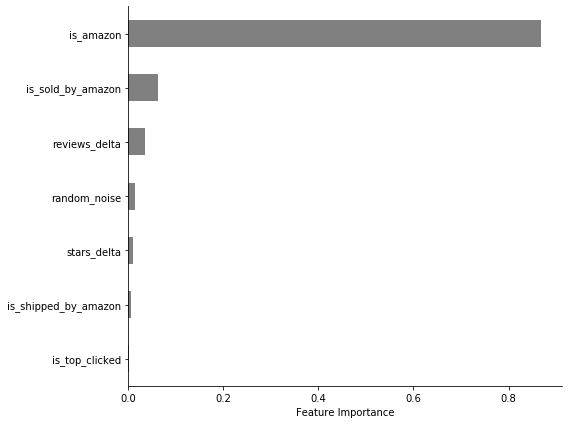

In [29]:
forest = RandomForestClassifier(n_estimators=n_trees, 
                                max_depth=max_tree_depth, 
                                max_features=max_features,
                                n_jobs=-1, random_state=random_seed)

score = fit_model(training_data, variable=cols, target=target, model=forest)
forest_importances = pd.Series(forest.feature_importances_, index=cols)
forest_importances.sort_values(inplace=True, ascending=True)
forest_importances.to_csv(fn_feature_importance, index=False)

fig, ax = plt.subplots(figsize=(8, 6))
forest_importances.plot.barh(ax=ax, color='grey')
# ax.set_ylabel("Features")
ax.set_xlabel("Feature Importance")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom') # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

## performance predicting who gets placed beyond the second posting

In [ ]:
permformance = []
for n in range(2, 41):
    print(f"Up to {n}...")
    training_data = produce_training_set(_df, last_product_position=n)
    
    cat2performance = {}
    forest = RandomForestClassifier(n_estimators=n_trees, 
                                    max_depth=max_tree_depth, 
                                    max_features=max_features,
                                    n_jobs=-1, 
                                    random_state=random_seed)
    score, std = fit_model_cv(training_data, variable=cols, target=target, model=forest)
    cat2performance["All Features"] = score
    for col in cols:
        clf =  RandomForestClassifier(n_estimators=n_trees, 
                                      max_depth=max_tree_depth,
                                      max_features=max_features,
                                      n_jobs=-1, 
                                      random_state=random_seed)
        iv = [c for c in cols if c not in col]
        score, std = fit_model_cv(training_data, variable=iv, target=target, model=clf)
        cat2performance[f"without {col}"] = score
    
    cat2performance["up_to_product"] = n
    permformance.append(cat2performance)

  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 2...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 3...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 4...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 5...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 6...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 7...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 8...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 9...


  0%|          | 0/4536 [00:00<?, ?it/s]

Up to 10...


 70%|██████▉   | 3154/4536 [00:17<00:13, 103.82it/s]

In [ ]:
df_performance = pd.DataFrame(permformance)

In [ ]:
df_performance

In [ ]:
ax = df_performance.set_index('up_to_product').plot(figsize=(7, 10),
                                                    kind='line',
                                                    alpha=.7,
                                                    style='.-',
                                                    title="Model Performance comparing the first product through the Nth product")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Distributions of features:

0 means they are both X
-2 means they are both NOT X
2 means one is X and one is NOT X

In [ ]:
training_data['is_amazon'].value_counts(normalize=True)

In [ ]:
training_data['is_shipped_by_amazon'].value_counts(normalize=True)

In [ ]:
training_data['is_sold_by_amazon'].value_counts(normalize=True)

In [ ]:
training_data['is_best_seller'].value_counts(normalize=True)

In [ ]:
training_data['is_top_clicked'].value_counts(normalize=True)

In [ ]:
training_data['is_amazons_choice'].value_counts(normalize=True)